# Spread of Infectious Diseases

MOD510 Mandatory project #3
Deadline: 21 November 2021 (23:59)

## Abstract

In this project the SI and SEIRD compartment models are used to model the first wave of the outbreak and spread of COVID-19. 

The least square estimation is used to find optimal values for the transmission rate beta by comparing the models with COVID data for specific locations. Hereby three optimisation algorithms are compared. While the fixed point iteration does not converge, the bisection and gradient descent methods suggest an optimal beta (e.g. 0.258 for the simple SI-model for Norway), assuming beta to be constant over time. 

An adaptive Runge-Kutta ODE solver using Richardson extrapolation to optimize the time stepsize is implemented to solve the ODEs of the SI and SEIRD model. It is compared to the Scipy odeint solver and produces matching results.

To more acurately fit the SI-model to the data, beta is assumed to exponentially decrease with lambda, which is representing the govermental response. By matching the SI-model with this imporved, time dependant beta to the data for different locations using the Scipy curve fitting tool, different governmental responses can be compared for different locations. For example the response of Germany (lambda = 0.017) was less effective compared to the response of Hubei (lambda = 0.062).

## Introduction

As of writing this report there have been almost 255 million confirmd COVID-19 cases worldwide, causing over 5.12 million reported deaths. [1]

The actual number of deaths, including unreported deaths, are estimated to be more then twice as high at about 12 million deaths. [2]

This makes the COVID-19 pandemic the 3rd largest pandemic in terms of total deaths since 1900 after the Spanish Flu at about 45 million deaths and HIV/AIDS at about 35 million deaths. [2][3][4]

The Outbreak and Spread of infectious diseases can be modeled by simple compartment models.



### Theory

The SI-model is a deterministic compartment model where ordinaray differential equations (ODEs) are used to determine the flow of people from the Susceptible (S) compartment to the Infected (I) compartment during the outbreak and spread of infectious diseases. The transmission rate, β, is an estimate to quantify the contact rate and disease transmition probability. At first two assumptions are made: 

Firstly, the number of contacts between persons is independent of time and population size. Secondly, the probability of getting infected (and becoming sick) is also constant. Therefore the transmission rate, β, is (at first) assumed to be constant. 

Later these assumptions are reformulated more precisely by decreasing beta exponentially over time and introducing lambda as the exponential factor.

The parameters are normalized in respect to the population to fit the model to the data. 

The SEIRD-model is an expanded version of the SI-model where the I compartment is split into the Exposed (E), Recovered (R) and Dead (D) compartments. ODEs for the compartments are introduced by considering the parameters Mean incubation (τ_inc) and Infectious period (τ_sick) and Infection fatality rate (fd). 

The adaptive Runge-Kutta method is applied to solve the ODEs of the SI and SEIRD model. Hereby Richardson extrapolation is used to adaptively choose the time step. This is compared to the Scipy odeint solver. 

The Least Square Estimation, in combination with the gradient descent, bisection and fixed point iteration methods, are used to find optimal beta values to fit the SI-model to the data. This method is compared to the Scipy Curve fitting tool, which is also used to calculate optimal beta values for the SEIRD-model and the lambda model for the time dependant SI-model.

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as si
import scipy.optimize as so
%matplotlib inline

## Class definition

Almost all functions created during the completion of this assignment are inside this class:

In [2]:
class COVID:
    def __init__(self,location,beta=0.5,lbd=0,filepath='./data/corona_data.dat',filepath_pop='./data/country_population.dat',
    I0=1,t_method='Manual',t_max=150,dt=1,population_method='Data'):
        """
        Initialise the Class for a specific location.

        Keyword arguments:
        location            -- the location to get the COVID Data for
        beta                -- the transmission rate. An estimate to quantify the contact rate and disease transmition probability. [0 < beta < 1]
        lbd                 -- rate at wich beta decreases exponentially over time if beta_timedependant of specific functions is set to [True]. [0 <= lbd <= 1]
        filepath            -- filepath and -name to the .dat file conataining the COVID data
        filepath_pop        -- filepath and -name to the .dat file containing the population data
        I0                  -- number of initially infected people
        t_method            -- method to calculate the upper limit for the used timeframe. ['Manual'] or ['Data']
            - Manual        -- set the upper limit manually using t_max. Usefull for only looking at the first wave
            - Data          -- set the upper limit to the last available day in the data
        t_max               -- the upper limit for the used timeframe [days]. Only used if t_methhod is set to ['Manual']
        dt                  -- temporal stepsize [days]
        population_method   -- method to calculate the population. ['Real'] or ['Data']
            - Real          -- set the population to the real population from the country_population.dat datafile
            - Data          -- set the population to the maximum number of confirmed cases from the data in the used timeframe    
        """
        # read data
        self.location = location

        self.filepath = filepath
        self.filepath_pop = filepath_pop

        self.df = pd.read_csv(self.filepath,sep='\t') # read in the whole dataframe
        
        self.Data_location = self.df[self.df['LOCATION'] == self.location] # get the data for the specified location

        self.df_pop = pd.read_csv(self.filepath_pop,sep='\t')
        
        # set t_max depending on the chosen method
        if t_method == 'Data':
            t_max = self.Data_location['ELAPSED_TIME_SINCE_OUTBREAK'].max()
            print(self.location,'t_max set to',t_max)
        elif t_method == 'Manual':
            t_max = t_max

        # create time array
        self.t = np.arange(0,t_max,dt)

        # set population depending on chosen method
        if population_method == 'Real':
            self.population = int(self.df_pop['Population'].loc[self.df_pop['Country'] == self.location])
        elif population_method == 'Data':
            self.population = int(self.Data_location['CONFIRMED'].loc[self.Data_location['ELAPSED_TIME_SINCE_OUTBREAK']<=self.t[-1]].iloc[-1])

        # get relevant data from dataframe and normalise
        self.confirmed_data = self.Data_location['CONFIRMED'].loc[self.Data_location['ELAPSED_TIME_SINCE_OUTBREAK']<=self.t[-1]]
        self.confirmed_data_norm = self.confirmed_data / self.population

        self.recovered_data = self.Data_location['RECOVERED'].loc[self.Data_location['ELAPSED_TIME_SINCE_OUTBREAK']<=self.t[-1]]
        self.recovered_data_norm = self.recovered_data / self.population

        self.deaths_data = self.Data_location['DEATHS'].loc[self.Data_location['ELAPSED_TIME_SINCE_OUTBREAK']<=self.t[-1]]
        self.deaths_data_norm = self.deaths_data / self.population

        self.beta = beta
        self.beta0 = beta
        self.lbd = lbd

        self.I0 = I0
        self.S0 = self.population - self.I0
        
        self.S0_norm = self.S0 / self.population
        self.I0_norm = self.I0 / self.population

    def plot_confirmcases(self,norm=True,plot_deaths=False,plot_both = False):
        """
        Plot the number of confirmed cases and/or deaths from the data.

        Keyword arguments:
        norm        -- normalize y-Axis (population). [True] or [False]
        plot_deaths -- plot only deaths [True] or only confirmed cases [False]
        plot_both   -- plot confirmed cases and deaths. [True] or [False]
        """
        time = self.t
        xlabel = 'Time since initial outbreak [days]'
        if norm==True:
            confirmed = self.confirmed_data_norm
            deaths = self.deaths_data_norm
            ylabel = 'Fraction of population \n'
        else:
            confirmed = self.confirmed_data
            deaths = self.deaths_data
            ylabel = 'Number of population \n'
        
        if plot_both == False:
            fig, ax = plt.subplots()
            ax.set_title(str(self.location + ' COVID Data'))
            ax.grid()
            
            ax.set_xlabel(xlabel)
            
            if plot_deaths==False:
                ax.plot(time, confirmed,'.', color='purple',label='Confirmed cases')
                ax.set_ylabel(ylabel+ 'confirmed cases')
            elif plot_deaths == True:
                ax.plot(time, deaths,'.', color='black',label='Confirmed deaths')
                ax.set_ylabel(ylabel + 'confirmed deaths')
            ax.legend()
        elif plot_both == True:
            fig, axs = plt.subplots(2)
            fig.suptitle(str(self.location + ' COVID Data'))
            axs[0].grid()
            axs[0].set_xlabel(xlabel)
            axs[0].set_ylabel(ylabel + 'confirmed cases')
            axs[0].plot(time, confirmed,'.', color='purple', label='Confirmed cases')
            axs[0].legend()
            axs[1].grid()
            axs[1].set_xlabel(xlabel)
            axs[1].set_ylabel(ylabel + 'confirmed deaths')
            axs[1].plot(time, deaths,'.', color='black', label='Confirmed deaths')
            axs[1].legend()

        return fig

    def SI_analytical(self,beta,norm=True,beta_timedependant=False,return_SI=False):
        """ 
        Calculate the analytical solution to the SI-model. Return an array of the number of infected people over time.

        Keyword arguments:
        beta                -- the transmission rate. [0 < beta < 1]
        norm                -- normalize the population. [True] or [False]
        beta_timedependant  -- use constant beta [False] or let beta decrease exponentially over time with lbd [True]
        """
        if norm == True:
            s0 = self.S0_norm
            i0 = self.I0_norm
            
        elif norm == False:
            s0 = self.S0
            i0 = self.I0

        if beta_timedependant==True:
            bt = (beta/self.lbd)*(1.0 - np.exp(-self.lbd*self.t)) if self.lbd > 0 else beta*self.t
        elif beta_timedependant==False:
            bt = beta*self.t

        s = ((s0/i0)*np.exp(-bt))/(1+(s0/i0)*np.exp(-bt))
        if norm == False:
            i = (s0+i0)/(1+((s0/i0)*np.exp(-bt)))
        else:
            i = 1/(1+((s0/i0)*np.exp(-bt)))
        if return_SI==False:
            return i
        elif return_SI==True:
            return s,i

    def SI_analytical_Deriv(self,beta,norm=True):
        """
        Calculate the analytical derivative of the number of infected people over time.

        Keyword arguments:
        beta    -- the transmission rate. [0 < beta < 1]
        norm    -- normalize the population. [True] or [False]
        """
        if norm == True:
            s0 = self.S0_norm
            i0 = self.I0_norm
            
        elif norm == False:
            s0 = self.S0
            i0 = self.I0

        i_deriv = ((s0/i0)*self.t*np.exp(-beta*self.t))/((1+(s0/i0)*np.exp(-beta*self.t))**2)
        return i_deriv

    def plot_analyt_SI_model(self, norm = True,plot_both=True):
        fig, ax = plt.subplots()
        ax.set_title(str(self.location+' SI-model'))
        ax.grid()
        
        if norm == False:
            if plot_both==True:
                S,I = self.SI_analytical(self.beta,norm=False,return_SI=True)   
                ax.plot(self.t,I,label='I')
                ax.plot(self.t,S,label='S')
            else: 
                I = self.SI_analytical(self.beta,norm=False)   
                ax.plot(self.t,I,label='I')
        else:
            if plot_both==True:
                S,I = self.SI_analytical(self.beta,return_SI=True)   
                ax.plot(self.t,I,label='I')
                ax.plot(self.t,S,label='S')
            else:
                I = self.SI_analytical(self.beta)   
                ax.plot(self.t,I,label='I')
        ax.legend()
        return fig

    def SSR(self,beta,norm=True):
        """
        Calculate the sum of squared residuals according to the least square method.

        Keyword arguments:
        beta    -- the transmission rate. [0 < beta < 1]
        norm    -- normalize the population. [True] or [False]
        """
        if norm == True:
            return sum((self.confirmed_data_norm - self.SI_analytical(norm=True,beta=beta))**2)
        elif norm == False:
            return sum((self.confirmed_data - self.SI_analytical(norm=False,beta=beta))**2)

    def SSR_Deriv(self,beta,norm=True):
        """
        Calculate the analytical derivative of the sum of squared residuals according to the least square method.

        Keyword arguments:
        beta    -- the transmission rate. [0 < beta < 1]
        norm    -- normalize the population. [True] or [False]
        """
        if norm == True:
            return -2 * np.sum((self.confirmed_data_norm - self.SI_analytical(norm=True,beta=beta)) * self.SI_analytical_Deriv(norm=True,beta=beta))
        elif norm == False:
            return -2 * np.sum((self.confirmed_data - self.SI_analytical(norm=False,beta=beta)) * self.SI_analytical_Deriv(norm=False,beta=beta))

    def SSR_Deriv_num(self,beta,norm=True,h=1e-10):
        """
        Calculate the numerical derivative of the sum of squared residuals according to the least square method.

        Keyword arguments:
        beta    -- the transmission rate. [0 < beta < 1]
        norm    -- normalize the population. [True] or [False]
        """
        return (self.SSR(beta=beta+h,norm=norm) - self.SSR(beta=beta-h,norm=norm))/(2*h)

    def plot_analyt_SI_and_SI_Deriv(self,norm=True):
        """
        Plot infected people and infection rate over time.

        Keyword arguments:
        norm    -- normalize y-Axis (population). [True] or [False]
        """
        plt.plot(self.t,self.SI_analytical(beta=self.beta,norm=norm),label='SI')
        plt.plot(self.t,self.SI_analytical_Deriv(beta=self.beta,norm=norm),label='SI derivative')
        plt.title(str(self.location)+' SI and it´s derivative over time')
        plt.xlabel('Days since Outbreak')
        plt.legend()
        plt.grid()

    def plot_SSR_and_SSR_Deriv_vs_Beta(self,beta_min=0,beta_max=1,d_beta=0.01,norm=True):
        """
        Plot SSR and SSR derivative over beta.

        Keyword arguments:
        beta_min    -- lower bound for beta [0 <= beta_min < beta_max]
        beta_max    -- upper bound for beta [beta_min < beta_max <= 1]
        d_beta      -- step size for beta [beta_min < d_beta < beta_max]
        norm        -- normalize y-Axis (population). [True] or [False]
        """
        BETA=np.arange(beta_min,beta_max,d_beta)

        SSR=[]
        SSR_Deriv_an=[]
        #SSR_Deriv_num=[]
        for beta in BETA:
            SSR.append(self.SSR(beta=beta,norm=norm))
            SSR_Deriv_an.append(self.SSR_Deriv(beta=beta,norm=norm))
            #SSR_Deriv_num.append(self.SSR_Deriv_num(beta=beta,norm=norm))

        fig, ax_left = plt.subplots()
        ax_right = ax_left.twinx()
        ax_left.set_title(str(self.location+' SSR and derivative of SSR'))

        ax_left.plot(BETA,SSR_Deriv_an, color='black', label='SSR derivative')
        ax_right.plot(BETA,SSR, color='red', label='SSR')
        ax_left.set_ylabel('The derivative of SSR')
        ax_right.set_ylabel('SSR')
        ax_left.set_xlabel('beta')
        ax_left.legend(loc='upper right')
        ax_right.legend(loc='lower right')
        ax_left.grid()

    def plot_data_vs_analyt_SI_model(self, norm = True, beta_timedependant = False):
        """
        Plot the data and model solution.

        Keyword arguments:
        norm                -- normalize y-Axis (population). [True] or [False]
        beta_timedependant  -- use constant beta [False] or let beta decrease exponentially over time with lbd [True]
        """
        if norm == False:
            if beta_timedependant==False:
                I = self.SI_analytical(self.beta,norm=False)
            else:
                I = self.SI_analytical(self.beta,beta_timedependant=True,norm=False)
            fig = self.plot_confirmcases(norm=False)
            ax = fig.axes[0]
            ax.plot(self.t,I,label='I (SI-model)')
        else:
            if beta_timedependant==False:
                I = self.SI_analytical(self.beta)
            else:
                I = self.SI_analytical(self.beta,beta_timedependant=True)
            fig = self.plot_confirmcases()
            ax = fig.axes[0]
            ax.plot(self.t,I,label='I (SI-model)')
        ax.legend()
        ax.set_title(str(self.location + ' Data VS SI-model'))

    def g_SSR_Deriv(self,beta):
        return beta + self.SSR_Deriv(beta)

    def fixed_point(self,EPS=1e-8):
        """
        Calculate optimal beta value using fixed-point method.
        """
        beta_old=self.beta
        eps = 1
        it=0
        while(eps>EPS):
            beta_new=self.g_SSR_Deriv(beta_old)
            eps=np.abs(beta_new-beta_old)
            beta_old=beta_new
            it += 1
        print('Found solution ' + str(beta_new) + ' after ' + str(it) + ' iterations')
        return beta_new

    def bisection(self,a,b,prec=1e-8,MAXIT=100):
        """
        Calculate optimal beta using bisection method.
        """
        if self.SSR_Deriv(beta = a)*self.SSR_Deriv(beta = b) >= 0:
            print('You need to bracket the root, f(a)*f(b) >= 0')
            return None
        an = a
        bn = b
        cn = 0.5*(an + bn)
        c_old = cn - 10*prec
        n=0
        while np.abs(cn-c_old)>=prec and n<MAXIT:
            c_old = cn
            f_cn = self.SSR_Deriv_num(beta = cn)
            if self.SSR_Deriv_num(beta =an)*f_cn < 0:
                bn = cn
            elif self.SSR_Deriv_num(beta =bn)*f_cn < 0:
                an = cn
            elif f_cn == 0:
                print('Found exact solution ', cn,' after ', n, 'iterations' )
                return cn, n
            else:
                print('Bisection method fails.')
                return None
            cn = 0.5*(an+bn)
            n += 1
        if n<MAXIT-1:
            print('Found solution ', cn,' after ', n, 'iterations' )
            return cn, n
        else:
            print('Max number of iterations: ', MAXIT, 'reached.')
            print('Try to increase MAXIT or decrease prec')
            print('Returning best guess, value of function is: ', f_cn)
            return None

    def gradient_descent(self,beta=0.6,learning_rate=.001,prec=1e-8,MAXIT=10):
        """
        Calculate optimal beta using gradient-descent method.
        """
        beta_old = beta
        for n in range(MAXIT):
            beta_new = beta_old - learning_rate*self.SSR_Deriv(beta=beta_old)
            if(abs(np.max(beta_new-beta_old))<prec):
                print('Found solution:', beta_new, 
                    ', after:', n, 'iterations.' )
                return beta_new
            beta_old=beta_new
        print('Max number of iterations: ', MAXIT, ' reached.') 
        print('Try to increase MAXIT or decrease prec')
        print('Returning best guess, value of function is: ', self.SSR(beta=beta_new))
        return beta_new


    ### VVV for Runge Kuta VVV

    def beta_t(self,t):
        """
        Calculate beta over t with beta scaling exponentially with lambda.

        Keyword arguments:
        t -- time array

        if lambda is 0 this will return a constant beta
        """
        return self.beta0*np.exp(-self.lbd*t)

    def SI_model(self,y,t):
        """
        Calculate S and I derivative according to SI-model.

        Keyword arguments:
        y   -- array[S,I]
        t   -- time
        """
        S=y[0]
        I=y[1]

        s_deriv = -self.beta_t(t)*I*S
        i_deriv = self.beta_t(t)*I*S

        return np.array([s_deriv,i_deriv])

    def SEIRD_model(self,y,t,fd=0.02,tau_inc=5,tau_sick=21):
        """
        Calculate S, E, I, R and D derivative according to SEIRD-model.

        Keyword arguments:
        y   -- array[S,E,I,R,D]
        t   -- time
        """
        S=y[0]
        E=y[1]
        I=y[2]
        R=y[3]
        D=y[4]

        s_deriv = -self.beta_t(t)*I*S
        e_deriv = self.beta_t(t)*I*S - (1/tau_inc) * E
        i_deriv = (1/tau_inc) * E - (1/tau_sick) * I
        r_deriv = (1-fd) * (1/tau_sick) * I
        d_deriv = fd * (1/tau_sick) * I

        return np.array([s_deriv,e_deriv,i_deriv,r_deriv,d_deriv])

    def cumnumcases (self,y):
        """
        Calculate sum of I+R+D.

        Keyword arguments:
        y -- array[S,E,I,R,D]
        """
        I=y[2]
        R=y[3]
        D=y[4]
        ct = np.sum(I+R+D)
        return ct

    def rk4_step(self,y,t,dt,func):
        """
        Calculate Runge-Kutta 4th order step. 

        Keyword arguments:
        y       -- array [S,I] or [S,E,I,R,D]
        t       -- time
        dt      -- time stepsize
        func    -- function (model). ["SI_model"] or ["SEIRD_model"]
        """
        k1=dt*func(y,t)
        k2=dt*func(y+0.5*k1,t+dt*0.5)
        k3=dt*func(y+0.5*k2,t+dt*0.5)
        k4=dt*func(y+k3,t+dt)
        return (k1+2*k2+2*k3+k4)/6

    def rk_adpative(self,func,y0,t0,tf,rel_tol=1e-5,abs_tol=1e-5,p=4,dt=1e-2,model='SEIRD'):
        """
        Solve ODE using adaptive Runge-Kutta 4th order algorithm.

        Keyword arguments:
        func    -- function (model). ["SI_model"] or ["SEIRD_model"]
        y0      -- array of initial guesses for [S,I] or [S,E,I,R,D]
        t0      -- starting time
        tf      -- final time
        rel_tol -- relative tolerance
        abs_tol -- absolute tolerance
        p       -- Runge Kutta order
        dt      -- initial stepsize for time
        model   -- model. ["SI_model"] or ["SEIRD_model"]
        """
        y=[]
        t=[]
        ct = []
        DT_array=[]
        n=len(y0)
        y_new=np.zeros(n)
        y1=np.zeros(n)
        y2=np.zeros(n)
        ti=t0
        t.append(ti)
        y.append(y0)
        ct.append(0)
        
        while (ti<=tf):
            y_old=y[-1]
            EPS=np.linalg.norm(y_old)*rel_tol+abs_tol
            eps=10*EPS

            while (eps>EPS):
                DT=dt
                DT_array.append(DT)

                y_new=y_old+self.rk4_step(y_old,ti,DT,func)
                y1=y_old+self.rk4_step(y_old,ti,DT*0.5,func)
                y2=y1+self.rk4_step(y1,ti+0.5*DT,DT*0.5,func)

                eps=np.linalg.norm(y2-y_new)/(2**p-1)

                dt=0.9*DT*(EPS/eps)**(1/(p+1))
            
            y.append((2**p*y2-y_new)/(2**p-1))
            if model == 'SEIRD':
                temp = (2**p*y2-y_new)/(2**p-1)
                ct.append(self.cumnumcases(temp))
            ti=ti+DT
            t.append(ti)
        if model == 'SEIRD':
            return np.array(t),np.array(y),np.array(DT_array),np.array(ct)
        return np.array(t),np.array(y),np.array(DT_array)

    def my_odeint(self,func,y0,report_times,rel_tol=1e-5,abs_tol=1e-5,p=4):
        """
        Solve ODE using adaptive Runge-Kutta 4th order algorithm for specific timesteps.

        Keyword arguments:
        func            -- function (model). ["SI_model"] or ["SEIRD_model"]
        y0              -- array of initial guesses for [S,I] or [S,E,I,R,D]
        report_times    -- array of report_times
        rel_tol         -- relative tolerance
        abs_tol         -- absolute tolerance
        p               -- Runge Kutta order
        """
        y=[]
        t=[]
        DT_array=[]
        n=len(y0)
        y_new=np.zeros(n)
        y1=np.zeros(n)
        y2=np.zeros(n)
        
        y.append(y0)

        delta_t_steps = report_times[1:]-report_times[0:-1]
        delta_t_report = delta_t_steps[0]
        delta_t = delta_t_report

        t0 = report_times[0]
        time = t0
        step = 0

        t.append(time)

        tfinal = report_times[-1]
        
        while time<=tfinal:
            y_old=y[-1]
            EPS = np.linalg.norm(y_old)*rel_tol+abs_tol
           
            eps = EPS+1
            while eps>EPS:
                DT = min(delta_t,delta_t_report)
              
                DT_array.append(DT)

                y_new=y_old+self.rk4_step(y_old,time,DT,func)
                y1=y_old+self.rk4_step(y_old,time,DT*0.5,func)
                y2=y1+self.rk4_step(y1,time+0.5*DT,DT*0.5,func)

                eps=np.linalg.norm(y2-y_new)/(2**p-1)
          
                delta_t = DT*(EPS/eps)**(p+1)

                y_old = (2**p*y2-y_new)/(2**p-1)

            time += DT
            delta_t_report -= DT
      
            t.append(time)

            if np.abs(delta_t_report)<10e-4:
                step += step
                y.append(y_old)
                delta_t_report = delta_t_steps[step]

        return np.array(t),np.array(y),np.array(DT_array)

    def f_SI(self,x,beta):
        """
        Calculate I according to SI-model for curve-fitting.
        """
        self.beta0 = beta
        S=self.S0_norm
        I=self.I0_norm
        _,f,_=self.my_odeint(y0=[S,I],report_times = x,func=self.SI_model)
        f = f[1:,]
        I=f[:,1]
        return I

    def model_curvefit(self,func,xdata,ydata,p0):
            popt=so.curve_fit(func,xdata=xdata,ydata=ydata,p0=p0)
            return popt

    def f_SEIRD(self,x,beta):
        """
        Calculate C according to SEIRD-model for curve-fitting.
        """
        self.beta0=beta
        S=self.S0_norm
        E = 0
        I=self.I0_norm
        R = 0
        D = 0
        _,f,_=self.my_odeint(y0=[S,E,I,R,D],report_times = x,func=self.SEIRD_model)
        f= f[1:,]
        C=f[:,2]+f[:,3]+f[:,4]
        return C
        
    def f_SI_beta_timedependant(self,x,beta,lbd):
        """
        Calculate I according to SI-model with timedependant beta for curve-fitting.
        """
        self.beta0=beta
        self.lbd=lbd
        S=self.S0_norm
        I=self.I0_norm
        _,f,_=self.my_odeint(y0=[S,I],report_times = x,func=self.SI_model)
        f= f[1:,]
        I=f[:,1]
        return I





## Exercise 1

### Part 1

Extract Data for a specific location (e.g. Hubei) from the Datafile and return it as a Dataframe:

In [3]:
Hubei = COVID(location='Hubei',population_method='Data',t_method='Data')
Hubei.Data_location

Hubei t_max set to 629


,LOCATION,TIME,ELAPSED_TIME_SINCE_OUTBREAK,NEW_CONFIRMED,CONFIRMED,NEW_DEATHS,DEATHS,RECOVERED
111804,Hubei,2020-01-22 23:59:00,0,0,444,0,17,28
111805,Hubei,2020-01-23 23:59:00,1,0,444,0,17,28
111806,Hubei,2020-01-24 23:59:00,2,105,549,7,24,31
111807,Hubei,2020-01-25 23:59:00,3,212,761,16,40,32
111808,Hubei,2020-01-26 23:59:00,4,297,1058,12,52,42
...,...,...,...,...,...,...,...,...
112429,Hubei,2021-10-08 23:59:00,625,0,68299,0,4512,0
112430,Hubei,2021-10-09 23:59:00,626,0,68299,0,4512,0
112431,Hubei,2021-10-10 23:59:00,627,0,68299,0,4512,0
112432,Hubei,2021-10-11 23:59:00,628,0,68299,0,4512,0


Plot confirmed cases for Hubei.

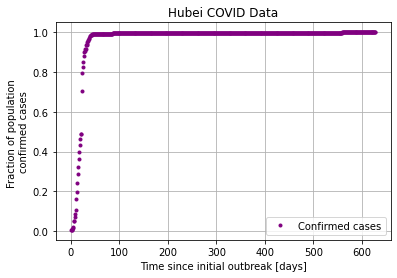

In [4]:
plotHubei = Hubei.plot_confirmcases(plot_deaths=False)

Plot confirmed cases and deaths in same figure for Hubei

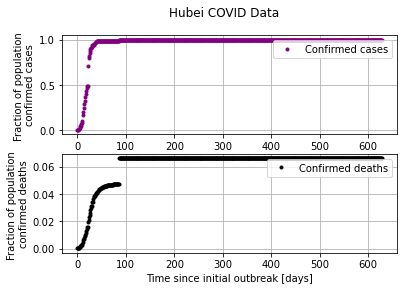

In [5]:
plotwithdeath = Hubei.plot_confirmcases(plot_deaths=True,plot_both=True)


### Part 2

Plot confirmed cases for Norway, Afghanistan, Sweden and Germany

Norway t_max set to 594
Afghanistan t_max set to 596
Sweden t_max set to 619
Germany t_max set to 624


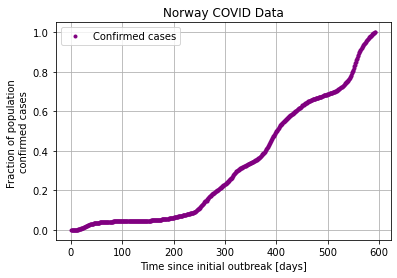

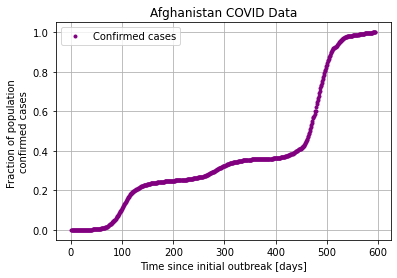

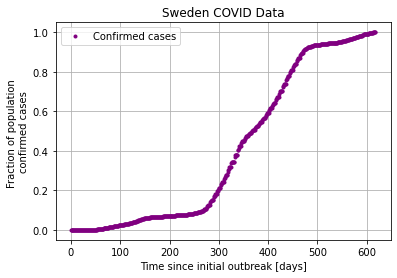

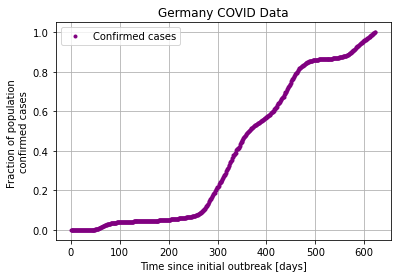

In [6]:
Norway = COVID(location='Norway',population_method='Data',t_method='Data')
Afghanistan = COVID(location='Afghanistan',population_method='Data',t_method='Data')
Sweden = COVID(location='Sweden',population_method='Data',t_method='Data')
Germany = COVID(location='Germany',population_method='Data',t_method='Data')

Data_Norway = Norway.plot_confirmcases()
Data_Afghanistan = Afghanistan.plot_confirmcases()
Data_Sweden = Sweden.plot_confirmcases()
Data_Germany = Germany.plot_confirmcases()


### Part 3

Plot cummulative deaths for Norway, Afghanistan, Sweden and Germany

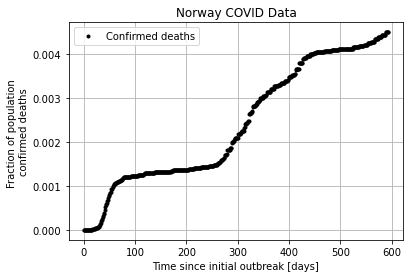

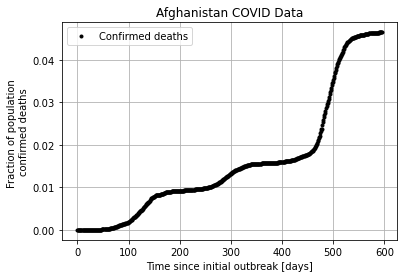

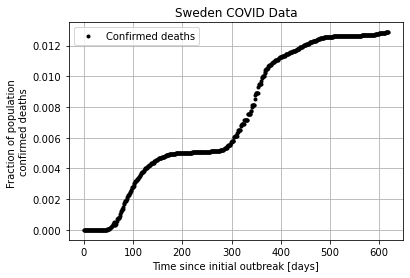

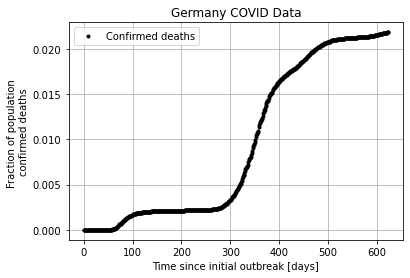

In [7]:
Data_Norway_death = Norway.plot_confirmcases(plot_deaths=True)
Data_Afghanistan_death = Afghanistan.plot_confirmcases(plot_deaths=True)
Data_Sweden_death = Sweden.plot_confirmcases(plot_deaths=True)
Data_Germany_death = Germany.plot_confirmcases(plot_deaths=True)


### Part 4


The SI-model (aswell as the SEIRD-model) will only represent the first infection wave. Therefore t_max has to be adjusted to limit the datarange. The simple SI-model assumes a constant transmission rate (beta). Beta therefore has to be adjusted to match the data. Even when an optimal beta is found (e.g. using the least-square method) the model won´t fit the data perfectly, since in reality beta changes over time with the govermental reaction to the pandemic (e.g. restrictions).

The plot below shows the confirmed cases from the observed data and predicted infections from the SI-model for Norway for the first 150 days (1st infection wave) of the pandemic. Note that beta is not perfectly adjusted here. The model only roughly follows the shape of the data, but doesn´t really match it very well.

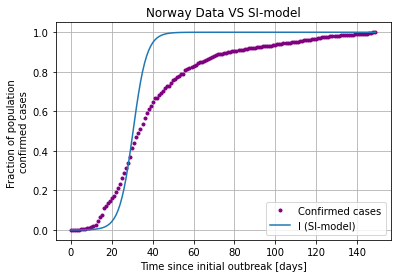

In [8]:
Norway = COVID(location='Norway',population_method='Data',t_method='Manual',t_max=150,beta=0.3)
Norway.plot_data_vs_analyt_SI_model()

## Exercise 2

### Part 1

SSR for Norway with beta = 0.3

In [9]:
Norway.SSR(beta=0.3)

2.4324998986468596

Derivative of SSR for Norway with beta = 0.3

In [10]:
Norway.SSR_Deriv(beta=0.3)

23.06841617840843

### Part 2

SSR and it´s derivative plotted against beta for several locations

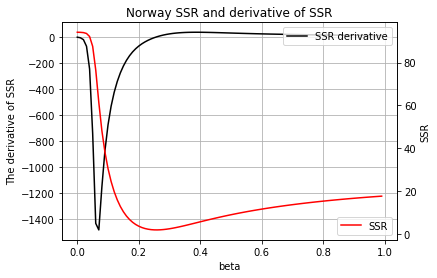

In [11]:
Norway = COVID(location='Norway',population_method='Data',t_method='Manual') #Fixed
Norway.plot_SSR_and_SSR_Deriv_vs_Beta()

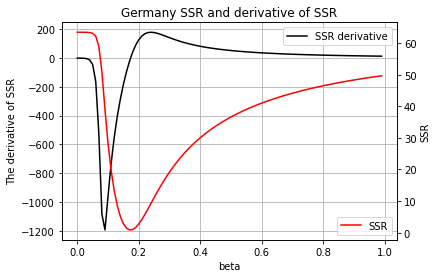

In [12]:
Germany = COVID(location='Germany',population_method='Data',t_method='Manual')
Germany.plot_SSR_and_SSR_Deriv_vs_Beta()

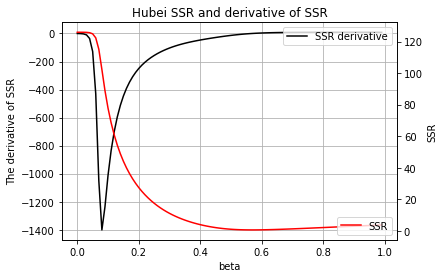

In [13]:
Hubei = COVID(location='Hubei',population_method='Data',t_method='Manual')
Hubei.plot_SSR_and_SSR_Deriv_vs_Beta()

When the valaue of SSR is minimum, the value of the derivative of SSR is zero. This is where the optimal beta can be found.

### Part 3

We have implemented three different methods to find the beta-value that minimizes SSR: Gradient descent, bisection, and fixed point iteration.

Fixed point iteration was not able to find the optimal value for beta, whereas gradient descent and bisection method found similar realistic values for an optimal beta.

In [14]:
Norway.gradient_descent(beta=0.15,MAXIT=10000,learning_rate=0.000001)

Max number of iterations:  10000  reached.
Try to increase MAXIT or decrease prec
Returning best guess, value of function is:  1.8872032874352076


0.25774343847494574

In [15]:
Germany.gradient_descent(beta=0.15,MAXIT=10000,learning_rate=0.000001)

Found solution: 0.17311954055648643 , after: 1463 iterations.


0.17311954055648643

In [16]:
Hubei.gradient_descent(beta=0.15,MAXIT=10000,learning_rate=0.000001)

Max number of iterations:  10000  reached.
Try to increase MAXIT or decrease prec
Returning best guess, value of function is:  0.6186162766697523


0.5344960656431164

In [17]:
Norway.fixed_point()

Found solution 30.108604494959348 after 2 iterations


30.108604494959348

In [18]:
Germany.fixed_point()

Found solution 53.16809739346127 after 2 iterations


53.16809739346127

In [19]:
Hubei.fixed_point()

Found solution -13.198930766654904 after 2 iterations


<ipython-input-2-4f687bd9cbc3>:143: RuntimeWarning: overflow encountered in exp
  s = ((s0/i0)*np.exp(-bt))/(1+(s0/i0)*np.exp(-bt))
<ipython-input-2-4f687bd9cbc3>:143: RuntimeWarning: overflow encountered in multiply
  s = ((s0/i0)*np.exp(-bt))/(1+(s0/i0)*np.exp(-bt))
<ipython-input-2-4f687bd9cbc3>:143: RuntimeWarning: invalid value encountered in true_divide
  s = ((s0/i0)*np.exp(-bt))/(1+(s0/i0)*np.exp(-bt))
<ipython-input-2-4f687bd9cbc3>:147: RuntimeWarning: overflow encountered in exp
  i = 1/(1+((s0/i0)*np.exp(-bt)))
<ipython-input-2-4f687bd9cbc3>:147: RuntimeWarning: overflow encountered in multiply
  i = 1/(1+((s0/i0)*np.exp(-bt)))
<ipython-input-2-4f687bd9cbc3>:169: RuntimeWarning: overflow encountered in exp
  i_deriv = ((s0/i0)*self.t*np.exp(-beta*self.t))/((1+(s0/i0)*np.exp(-beta*self.t))**2)
<ipython-input-2-4f687bd9cbc3>:169: RuntimeWarning: overflow encountered in multiply
  i_deriv = ((s0/i0)*self.t*np.exp(-beta*self.t))/((1+(s0/i0)*np.exp(-beta*self.t))**2)
<ipython-inp

-13.198930766654904

In [20]:
solution, no_iterations = Norway.bisection(-0.2,0.65)
print ("Number of function calls:" , str(1 + 2*no_iterations))
print ("A solution is:", str(solution))


Found solution  0.2577700432389975  after  26 iterations
Number of function calls: 53
A solution is: 0.2577700432389975


In [21]:
solution, no_iterations = Germany.bisection(-0.1,2)
print ("Number of function calls:" , str(1 + 2*no_iterations))
print ("A solution is:", str(solution))


Found solution  0.17312108390033246  after  27 iterations
Number of function calls: 55
A solution is: 0.17312108390033246


In [22]:
solution, no_iterations = Hubei.bisection(-0.2,0.65)
print ("Number of function calls:" , str(1 + 2*no_iterations))
print ("A solution is:", str(solution))


Found solution  0.5689907345920799  after  26 iterations
Number of function calls: 53
A solution is: 0.5689907345920799


We can not expect fixed point iteration to find a sensible value for beta, since it does not converge. It may only find a sensible solution with a very good initial guess for beta.

As long as the derivative of SSR for the lower beta is below 0 and the upper beta is above 0 (See SSR plot above) the bisection will reliably converge and produce a realistic value for an optimal beta.

As long as the initial guess for beta is on the right side of the valley of the derivative of SSR (See SSR plot above) and the learning rate is sufficiently small while the maximum number of iterations is sufficiently large, the gradient descent method will reliably converge and produce a realistic value for an optimal beta.

## Exercise 3

### Part 1

For implementation of the adaptive Runge Kutta ODE solver see class.

### Part 2

As the bisection and gradient descent method suggest beta=0.258 produces optimal results for Norway using the simple SI-model

In [23]:
Norway = COVID(location='Norway',population_method='Data',t_method='Manual',t_max=150,beta=0.258)

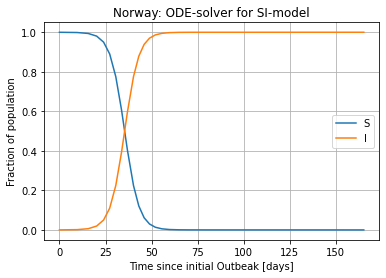

In [24]:
xa_rk_SI,ya_rk_SI,step_rk_SI=Norway.rk_adpative(y0=[Norway.S0_norm,Norway.I0_norm],t0=Norway.t[0],tf=Norway.t[-1],func=Norway.SI_model,model = 'SI')
plt.plot(xa_rk_SI,ya_rk_SI)
plt.xlabel('Time since initial Outbeak [days]')
plt.ylabel('Fraction of population')
plt.title(Norway.location+': ODE-solver for SI-model')
plt.legend(['S','I'])
plt.grid()

### Part 3

When compared with the analytical solution to the simple SI-model, the Runge-Kutta solution matches perfectly.

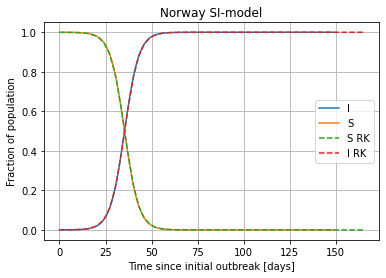

In [25]:
fig = Norway.plot_analyt_SI_model()
ax = fig.axes[0]
ax2 = fig.axes[0]
ax.plot(xa_rk_SI, ya_rk_SI[:,0],linestyle='dashed',label='S RK')
ax2.plot(xa_rk_SI, ya_rk_SI[:,1],linestyle='dashed',label='I RK')
ax.legend()
ax.set_xlabel('Time since initial outbreak [days]')
ax.set_ylabel('Fraction of population')
plt.show()

In [26]:
abs_error_at_tf = ya_rk_SI[:,1][-1] - Norway.SI_analytical(beta=0.258)[-1]
print('Absolute error at t = tf:',abs_error_at_tf)

Absolute error at t = tf: 9.185355665319861e-05


The numerical solver reproduces the analytical result at t = tf within the expected numerical accuracy.

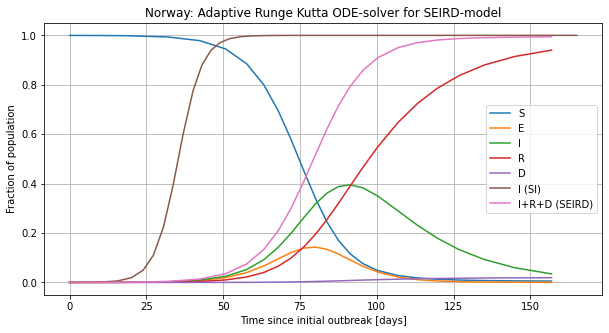

In [27]:
xa_rk_SEIRD,ya_rk_SEIRD,step_rk_SEIRD,ct=Norway.rk_adpative(y0=[Norway.S0_norm,0,Norway.I0_norm,0,0],t0=Norway.t[0],tf=Norway.t[-1],func=Norway.SEIRD_model)

plt.figure(figsize=(10,5))
plt.plot(xa_rk_SEIRD,ya_rk_SEIRD)
plt.plot(xa_rk_SI,ya_rk_SI[:,1])
plt.plot(xa_rk_SEIRD,ct)
plt.xlabel('Time since initial outbreak [days]')
plt.ylabel('Fraction of population')
plt.title(Norway.location+': Adaptive Runge Kutta ODE-solver for SEIRD-model')
plt.legend(['S','E','I','R','D','I (SI)','I+R+D (SEIRD)'])
plt.grid()


As can be seen in the plot above I (SI) and I+R+D (SEIRD) both rise up to 1 (100% of confirmed cases from the data 150 days after the initial outbreak).

However, they don´t line up on the time-scale. The SI- and SEIRD-model require different values for an optimal beta to match the data, but the optimal beta from the SI-model was used for both models.

## Exercise 4

### Part 1

For implementation of the new ODE solver see my_odeint function in the class.

### Part 2

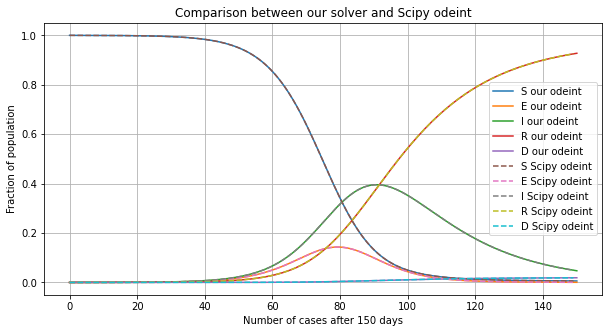

In [28]:
# Our Solver
xa_ode_SEIRD,ya_ode_SEIRD,step_ode_SEIRD=Norway.my_odeint(y0=[Norway.S0_norm,0,Norway.I0_norm,0,0],report_times = Norway.t,func=Norway.SEIRD_model)

# SciPy
y=si.odeint(func=Norway.SEIRD_model,y0=[Norway.S0_norm,0,Norway.I0_norm,0,0],t=np.arange(Norway.t[0],Norway.t[-1],1e-2))

# Plot to compare
plt.figure(figsize=(10,5))
plt.title('Comparison between our solver and Scipy odeint')
plt.xlabel('Number of cases after 150 days')
plt.ylabel('Fraction of population')
plt.plot(xa_ode_SEIRD,ya_ode_SEIRD)
plt.plot(np.arange(Norway.t[0],Norway.t[-1],1e-2),y,linestyle='dashed')
plt.legend(labels=['S our odeint','E our odeint','I our odeint','R our odeint','D our odeint','S Scipy odeint','E Scipy odeint','I Scipy odeint','R Scipy odeint','D Scipy odeint'])
plt.grid()

As the graph above shows, the output from our solver agrees with the Scipy odeint solver.

### Part 3 and 4

In [29]:

NorwayCurve = COVID(location='Norway',population_method='Data',t_method='Manual',beta=0.1)
popt_SI = Norway.model_curvefit(NorwayCurve.f_SI,xdata=NorwayCurve.t,ydata=NorwayCurve.confirmed_data_norm,p0=NorwayCurve.beta)
popt_SEIRD = Norway.model_curvefit(NorwayCurve.f_SEIRD,xdata=NorwayCurve.t,ydata=NorwayCurve.confirmed_data_norm,p0=NorwayCurve.beta)
result_SI = popt_SI[0]
beta_SI = result_SI[0]
result_SEIRD = popt_SEIRD[0]
beta_SEIRD = result_SEIRD[0]


print("\nBeta for simple SI-model: "+ str(round(beta_SI,3)),
    "\nBeta for SEIRD-model: "+ str(round(beta_SEIRD,3)))


Beta for simple SI-model: 0.251 
Beta for SEIRD-model: 0.735


The result for the simple SI-model (0.251) is close to the result from the bisection- and gradient descent method (0.258).

The optimal beta valaue in the SEIRD-model is greater than in the simple SI-model, because the SEIRD-model uses more parameters.

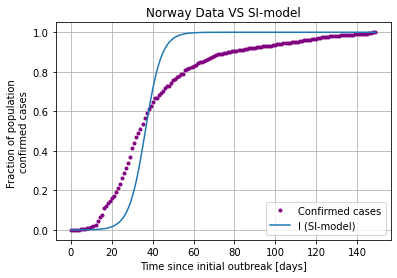

In [30]:
NorwayCurveFited = COVID(location='Norway',population_method='Data',t_method='Manual',beta=beta_SI)
NorwayCurveFited.plot_data_vs_analyt_SI_model(beta_timedependant=True,norm=True) 

The plot above shows the analytical solution of the simple SI-model in comparison to the data with an optimal beta. As explained earlier, this gives the best match for the simple SI-model, but since beta is assumed to be constant here, the model won´t line up with the data perfectly.

### Part 5

In [31]:

NorwayBtd = COVID(location='Norway',population_method='Data',t_method='Manual',t_max=150,beta=0.257,lbd = 0.01)
popt_SI_btd = NorwayBtd.model_curvefit(NorwayBtd.f_SI_beta_timedependant,xdata=NorwayBtd.t,ydata=NorwayBtd.confirmed_data_norm,p0=[NorwayBtd.beta,NorwayBtd.lbd])
result = popt_SI_btd[0]
beta_SI_btd = result[0]
lbd_SI_btd = result[1]

print("\nBeta0 for SI model: "+ str(round(beta_SI_btd,3)),"\nLambda for SI model: "+ str(round(lbd_SI_btd,3)))


Beta0 for SI model: 0.494 
Lambda for SI model: 0.041


For Norway the optimal beta0 (0.494) is higher than the optimal beta for the simple SI-model (0.258)

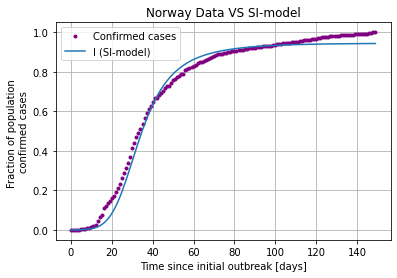

In [32]:
NorwayBtdFited = COVID(location='Norway',population_method='Data',t_method='Manual',beta=beta_SI_btd,lbd=lbd_SI_btd)
NorwayBtdFited.plot_data_vs_analyt_SI_model(beta_timedependant=True,norm=True)

In [33]:

GermanyBtd = COVID(location='Germany',population_method='Data',t_method='Manual',t_max=150,beta=0.257,lbd = 0.01)
popt_SI_btd = GermanyBtd.model_curvefit(GermanyBtd.f_SI_beta_timedependant,xdata=GermanyBtd.t,ydata=GermanyBtd.confirmed_data_norm,p0=[GermanyBtd.beta,GermanyBtd.lbd])
result = popt_SI_btd[0]
beta_SI_btd = result[0]
lbd_SI_btd = result[1]

print("\nBeta0 for SI model: "+ str(round(beta_SI_btd,3)),"\nLambda for SI model: "+ str(round(lbd_SI_btd,3)))


Beta0 for SI model: 0.292 
Lambda for SI model: 0.017


For Germany the optimal beta0 (0.292) is higher than the optimal beta for the simple SI-model (0.173)

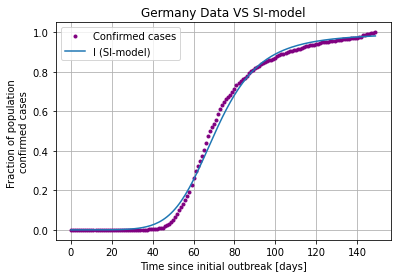

In [34]:
GermanyBtdFited = COVID(location='Germany',population_method='Data',t_method='Manual',beta=beta_SI_btd,lbd=lbd_SI_btd)
GermanyBtdFited.plot_data_vs_analyt_SI_model(beta_timedependant=True,norm=True)

In [35]:
HubeiBtd = COVID(location='Hubei',population_method='Data',t_method='Manual',t_max=150,beta=0.257,lbd = 0.01)
popt_SI_btd = HubeiBtd.model_curvefit(HubeiBtd.f_SI_beta_timedependant,xdata=HubeiBtd.t,ydata=HubeiBtd.confirmed_data_norm,p0=[HubeiBtd.beta,HubeiBtd.lbd])
result = popt_SI_btd[0]
beta_SI_btd = result[0]
lbd_SI_btd = result[1]

print("\nBeta0 for SI model: "+ str(round(beta_SI_btd,3)),"\nLambda for SI model: "+ str(round(lbd_SI_btd,3)))


Beta0 for SI model: 0.986 
Lambda for SI model: 0.062


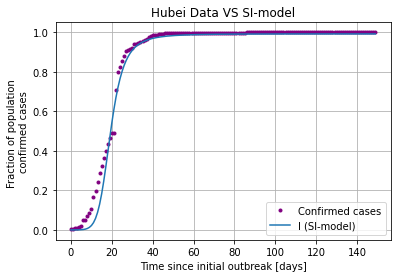

In [36]:
HubeiBtdFited = COVID(location='Hubei',population_method='Data',t_method='Manual',beta=beta_SI_btd,lbd=lbd_SI_btd)
HubeiBtdFited.plot_data_vs_analyt_SI_model(beta_timedependant=True,norm=True)

Assuming high lambda implies a strong governmental response out of the three locations Hubei reacted the fastest (0.062), Norway the second fastest (0.041) and Germany the slowest (0.017). This matches our observations during the pandemic.

Using the models and fitting them to the data allows us to generate insight into the parameters that set them apart for different locations. As described above we can for example derive the govermental response to the pandemic from the fitted model and rank different approaches to reacting to a pandemic from different governments accordingly. This helps to define the right approach for future pandemics. 

Note that the best approach might be different for different locations, depending on factors like population density and medical systems, which can be seen in the different beta0 values.

These insights are most likely not gained from just looking at the data.

## Conclusion

Compartment models are a relatively simple approach to modeling the spread of infectious diseases. The use of ODEs means they can be efficiently solved by common solvers. The adaptive Runge-Kutta method using Richardson extrapolation combines high accuracy (Runge-Kutta) with high efficiency (Richardson extrapolation).

When simplyfying assumptions are made, a model might not be able to fit the data perfectly, as in the case with the simple SI-model,where beta is assumed to be constant. By redefining those assumptions a model can become more precise, as in the case, where beta was exponentially decreased using lambda.

In order to fit a model to data the least square estimation, espescially in form of existing tools like the Scipy curvefit function, provides a useful tool to find optimal model parameters (like beta and lambda). Different optimizers (like gradient descent and bisection method) might work better than others (fixed point iteration).

From fitting a model to data further insights into the data can be gained, as in the comparison of different lambdas as a quantification govermental response efficiency.

The main limitation of the used SI- and SEIRD-model is, that they are only usefull for the first wave of the pandemic. In future work the models could be modified to be able to automatically adapt to the timeframe of an infection wave. Moreover, multiple waves might be able to be modeled properly by predicting beta changing over time more precisely, including allowing it to increase again.

## Selfreflection

 - Learned more about:
    - Using compartment models to simulate the spread of infectious diseases
    - Implementing optimizers and SSR to fit a model to data
    - Implementing an addaptive Runge Kutta ODE solver
      - Using Richardson extrapolation to adapt the time stepsize
    - Using the Scipy odeint ODE solver
    - Using the Scipy curvefitting tool
    - Using plots to compare different models and data
    - The limitations of compartment models when making simplyfying assumptions (e.g. beta = constant)
    - The additional insights to be gained from matching models to data
    - Algorithms that are used for finding roots or minimum of functions, which in my opinion is one of the most useful topics in mathematics and computer science area.
    - How to model the spread of diseases. Although this project was only about Covid-19, the approch is similar for other kind of problems.
    - How to solve non-linear equations, and why we need them.
    - How to implement our code more efficient and undrestanble using class.

 - Faced difficulties while:
    - Implementing the ODE solvers
    - Bug fixing  
    -  Working on curvefit function especially when we want to fit the time dependant beta.
    - Working on combination of our solver and curvefit function, we faced some errors like "not a proper call for float array".
    - Working on root finding algorithms, our dSSR values were not correct so we couldn't work with these algorithms. Later we found out that the initialization of variabls were wrong.

## References ##

- [1] World Health Organization. WHO Coronavirus (COVID-19) Dashboard, 2021. https://covid19.who.int/, 19/11/2021
- [2] Institute for Health Metrics and Evaluation. COVID-19 Projections. University of Washington, 2021. https://covid19.healthdata.org/global?view=cumulative-deaths&tab=trend, 19/11/2021
- [3] Nicholas LePan and Harrison Schell. Visualizing the History of Pandemics. Visual Capitalist, 2020 https://www.visualcapitalist.com/history-of-pandemics-deadliest/, 19/11/2021
- [4] UNAIDS. Global HIV & AIDS statistics — Fact sheet, 2021 https://www.unaids.org/en/resources/fact-sheet, 19/11/2021